In [2]:
pip install opencv-python-headless numpy matplotlib


In [3]:
pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [4]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.ops import nms


# **Compute Dense Optical Flow**
We used Farneback's method in opencv

In [5]:
def compute_flow(frame1, frame2):
    # Convert frames to grayscale
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # Blur images for better flow calculation
    gray1 = cv2.GaussianBlur(gray1, (3,3), sigmaX=5)
    gray2 = cv2.GaussianBlur(gray2, (3,3), sigmaX=5)

    # Compute optical flow using Farneback’s method
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.75, 3, 5, 3, 10, 1.2, 0)
    return flow


In [6]:
def get_flow_viz(flow):
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 1] = 255

    # Compute magnitude and angle of flow
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2  # Angle in degrees
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Normalize magnitude

    # Convert HSV to RGB for display
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb, mag 

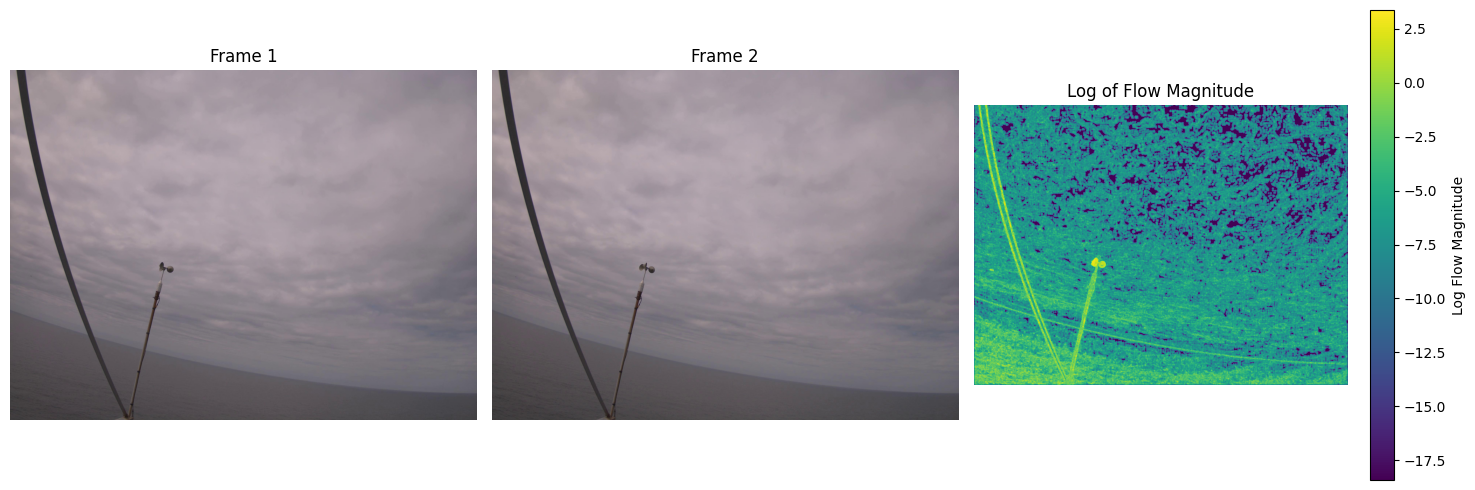

In [8]:
image_path1 = r"C:\Users\hilal\OneDrive\Bureau\PROCESSED\VIDEO_360\DATASET_SENSEA\images\sequence=1_video-20220511_132051-00_frame=3720.jpg"
image_path2 = r"C:\Users\hilal\OneDrive\Bureau\PROCESSED\VIDEO_360\DATASET_SENSEA\images\sequence=1_video-20220511_132051-00_frame=3721.jpg"

frame1 = cv2.imread(image_path1)
frame2 = cv2.imread(image_path2)

# Compute optical flow
flow = compute_flow(frame1, frame2)

# Get flow visualization and magnitude
flow_viz, mag = get_flow_viz(flow)

# Compute log of the magnitude (adding a small constant to avoid log(0))
log_mag = np.log(mag + 1e-8)

# Plot the results
plt.figure(figsize=(15, 5))

# Display the first frame
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
plt.title("Frame 1")
plt.axis("off")

# Display the second frame
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
plt.title("Frame 2")
plt.axis("off")

# Display the log of the flow magnitude
plt.subplot(1, 3, 3)
plt.imshow(log_mag, cmap="viridis")
plt.colorbar(label="Log Flow Magnitude")
plt.title("Log of Flow Magnitude")
plt.axis("off")

plt.tight_layout()
plt.show()

- compute_flow function calculates the dense optical flow between the two frames.
- get_flow_viz function generates a color-coded image of the optical flow and computes the magnitude of the flow vectors.
- Logarithmic magnitude visualization: We take the log of the magnitude to enhance visibility, especially for small values, and display it with a color map.

- The magnitude represents the amount of movement (or displacement) between corresponding points in consecutive frames : Low magnitude (values near -17.5 in the log scale) indicates areas with little to no motion and high magnitude (values near 2.5 in the log scale): Indicates areas with significant motion.

# **Get the Motion Mask**
We will need to apply a threshold to the optical flow and obtain a binary motion mask. In practice we will use Blurring and Morphological Operations to improve the quality of the motion mask.

In [9]:
def get_motion_mask(flow_mag, motion_thresh=1, kernel=np.ones((7,7), dtype=np.uint8)):
    motion_mask = np.uint8(flow_mag > motion_thresh) * 255
    motion_mask = cv2.erode(motion_mask, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    return motion_mask


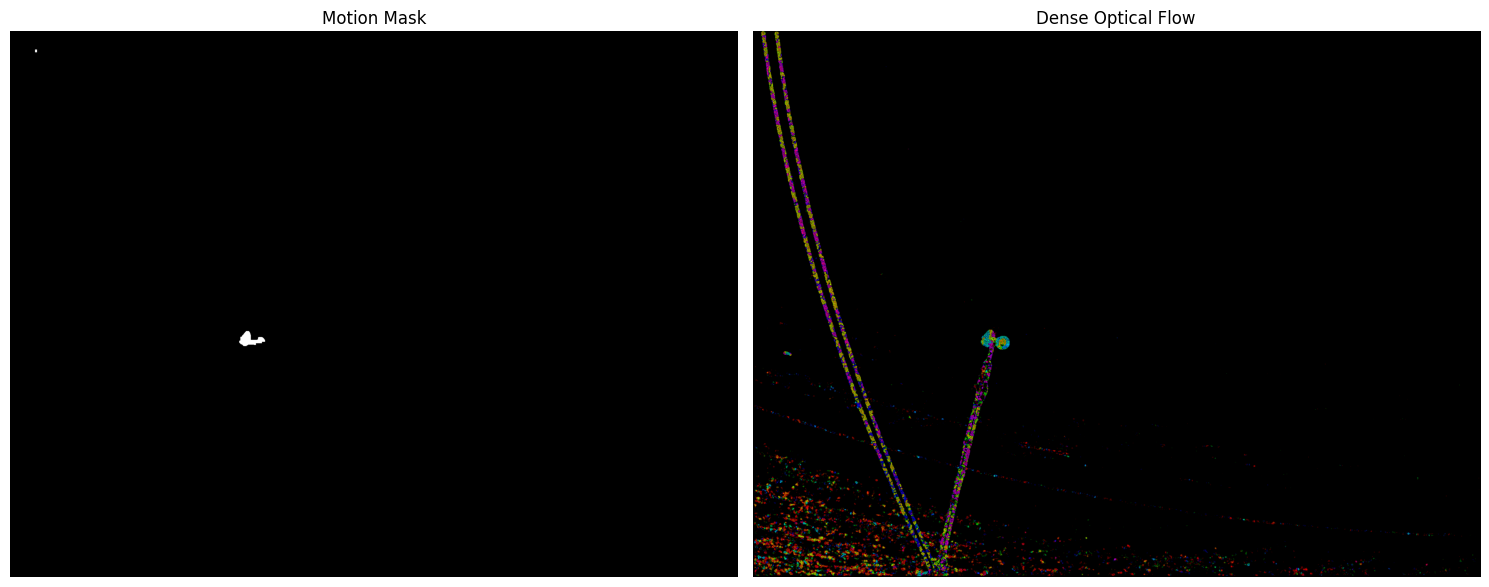

In [10]:
# Compute Dense Optical Flow
flow = compute_flow(frame1, frame2)

# Separate flow into magnitude and angle
mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

# Get optical flow visualization
rgb, _ = get_flow_viz(flow)

# Define variable motion threshold based on image height (e.g., 1080 pixels)
min_thresh = 0.3
max_thresh = 1.0
motion_thresh = np.c_[np.linspace(min_thresh, max_thresh, mag.shape[0])].repeat(mag.shape[1], axis=-1)

# Get motion mask with position-dependent threshold
mask = get_motion_mask(mag, motion_thresh=motion_thresh)

# Display the mask and the dense optical flow visualization
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(mask, cmap='gray')
ax[0].set_title("Motion Mask")
ax[0].axis("off")

ax[1].imshow(rgb * 50)  # Scaling to make flow visualization more visible
ax[1].set_title("Dense Optical Flow")
ax[1].axis("off")

plt.tight_layout()
plt.show()

- Dense optical flow calculates the displacement (movement) of every pixel between two consecutive frames. This means it gives a detailed map of both the direction and the speed of motion across the entire image.
- The motion mask, on the other hand, only highlights regions of significant motion by thresholding the optical flow magnitude. It simplifies the detailed flow information into a basic mask that shows only the areas that are moving and ignores everything else.

The motion mask is useful for identifying general movement but captures unintended background motion, failing to isolate the bird’s specific motion . Whereas the dense optical flow provides a more precise analysis that accurately distinguishes the bird’s unique movement from other subtle background motions.


# **Get detections**
We leverage optical flow-based contour detection to identify and refine bounding boxes around moving objects, using flow magnitude and angle consistency for precise detections.

In [11]:
def get_contour_detections(mag, ang, angle_thresh=1, mag_thresh=0.5, area_thresh=300):
    """ Obtain detections from contours based on the optical flow magnitude and angle.
        Inputs:
            mag - Optical flow magnitude
            ang - Optical flow angle
            angle_thresh - threshold for flow angle standard deviation
            mag_thresh - threshold for flow magnitude to consider motion
            area_thresh - minimum contour area for a valid detection
        Outputs:
            detections - array of proposed detection bounding boxes and scores 
                         [[x1, y1, x2, y2, score]]
    """
    # Threshold the magnitude to get areas of significant motion
    motion_mask = np.uint8(mag > mag_thresh) * 255
    contours, _ = cv2.findContours(motion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    angle_thresh = angle_thresh * ang.std()
    detections = []

    for cnt in contours:
        # Get bounding box and area of contour
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h

        # Check flow angle consistency within the contour
        mask = np.zeros_like(motion_mask)
        cv2.drawContours(mask, [cnt], -1, 255, -1)
        flow_angle = ang[mask == 255]

        # Filter based on area and angle consistency
        if area > area_thresh and flow_angle.std() < angle_thresh:
            detections.append([x, y, x + w, y + h, area])

    return np.array(detections)

In [12]:
def non_max_suppression(bboxes, scores, threshold=0.3):
    # Convert bounding boxes to tensor for PyTorch NMS
    bboxes_tensor = torch.tensor(bboxes, dtype=torch.float32)
    scores_tensor = torch.tensor(scores, dtype=torch.float32)
    keep = nms(bboxes_tensor, scores_tensor, threshold)
    return bboxes_tensor[keep].numpy().astype(int)


In [13]:
def get_detections(frame1, frame2, mag_thresh=0.5, bbox_thresh=300, nms_thresh=0.1, angle_thresh=1):
    """ Main function to get detections via Optical Flow-based contour detection
        Inputs:
            frame1 - Grayscale frame at time t
            frame2 - Grayscale frame at time t + 1
            mag_thresh - Minimum magnitude threshold for motion
            bbox_thresh - Minimum contour area threshold
            nms_thresh - IOU threshold for Non-Maximal Suppression
            angle_thresh - Threshold for angle consistency within a contour
        Outputs:
            detections - list with bounding box locations of all detections
                bounding boxes are in the form of: (xmin, ymin, xmax, ymax)
    """
    # Compute optical flow
    flow = compute_flow(frame1, frame2)

    # Separate into magnitude and angle
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Get initial detections based on optical flow contours
    detections = get_contour_detections(mag, ang, angle_thresh=angle_thresh, mag_thresh=mag_thresh, area_thresh=bbox_thresh)

    # Separate bounding boxes and scores for non-maximal suppression
    bboxes = detections[:, :4]
    scores = detections[:, -1]

    # Perform Non-Maximal Suppression on initial detections
    return non_max_suppression(bboxes, scores, threshold=nms_thresh)


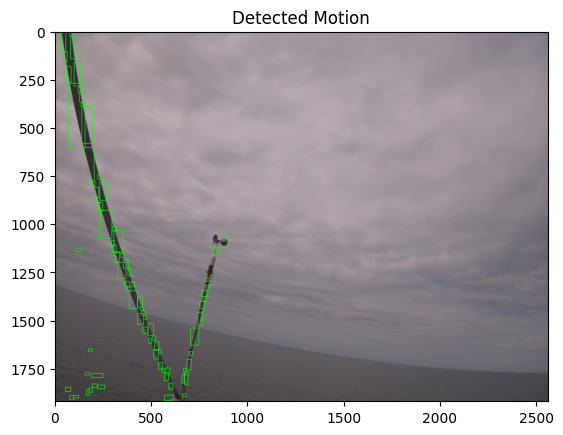

In [14]:

# Load two consecutive frames
frame1 = cv2.imread(image_path1) 
frame2 = cv2.imread(image_path2)

# Get detections
detections = get_detections(frame1, frame2)

# Draw bounding boxes
for bbox in detections:
    x1, y1, x2, y2 = bbox
    cv2.rectangle(frame1, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display results
plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
plt.title("Detected Motion")
plt.show()


On a séléctionné un dataSet mettant en scène des images sans l'objet central et avec un oiseau qui se déplace de façon claire


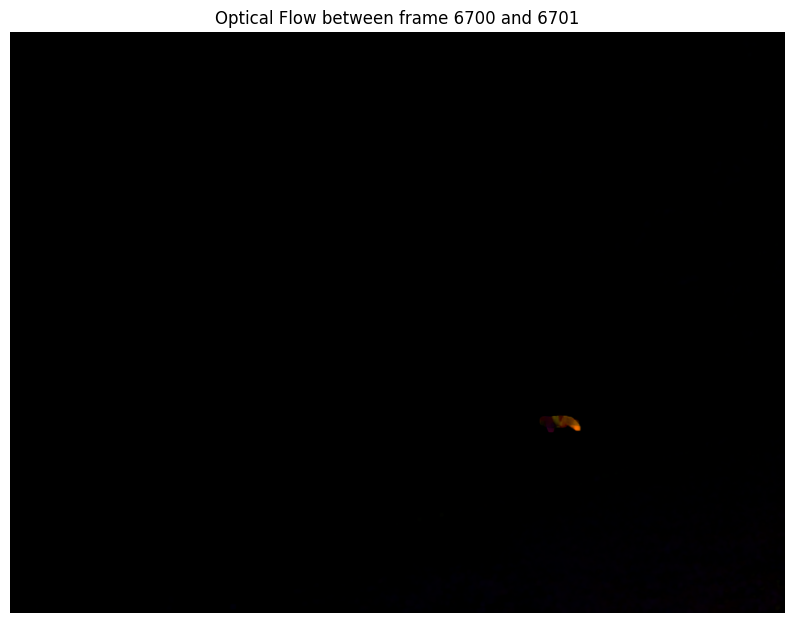

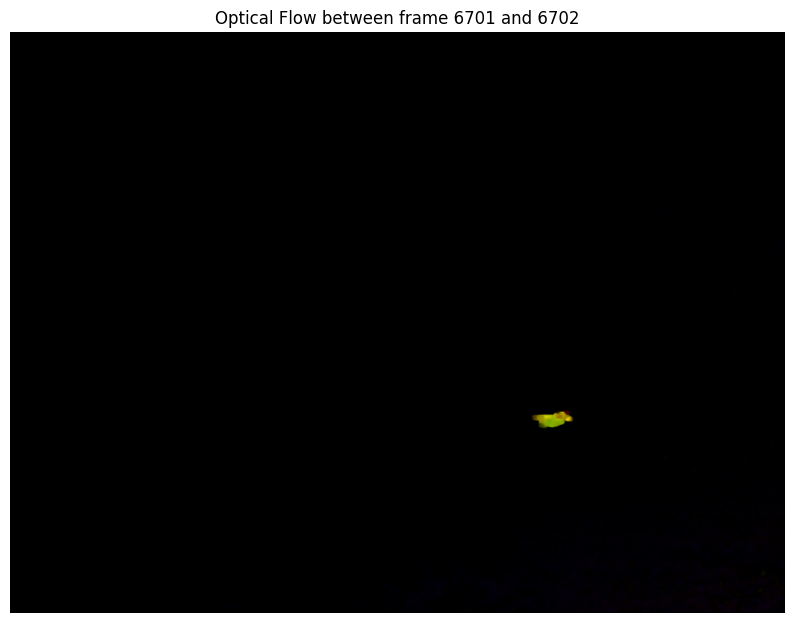

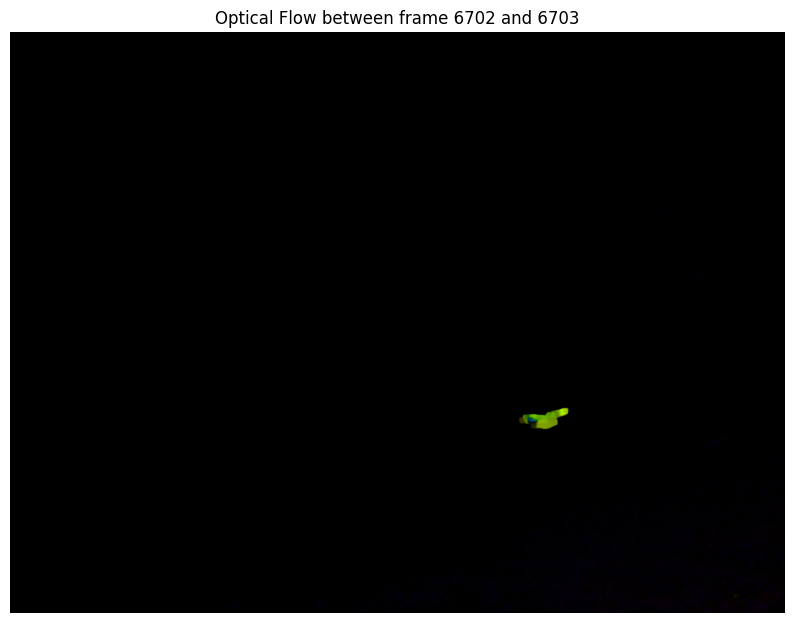

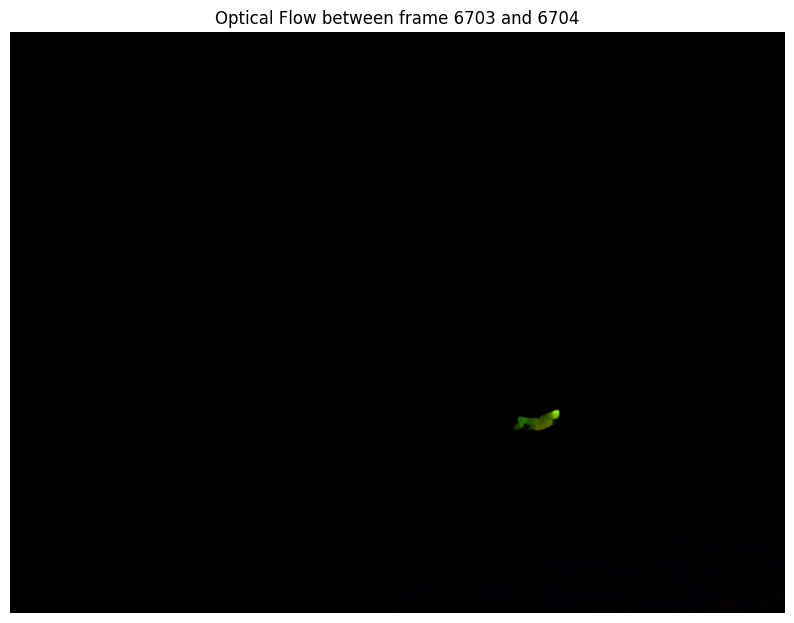

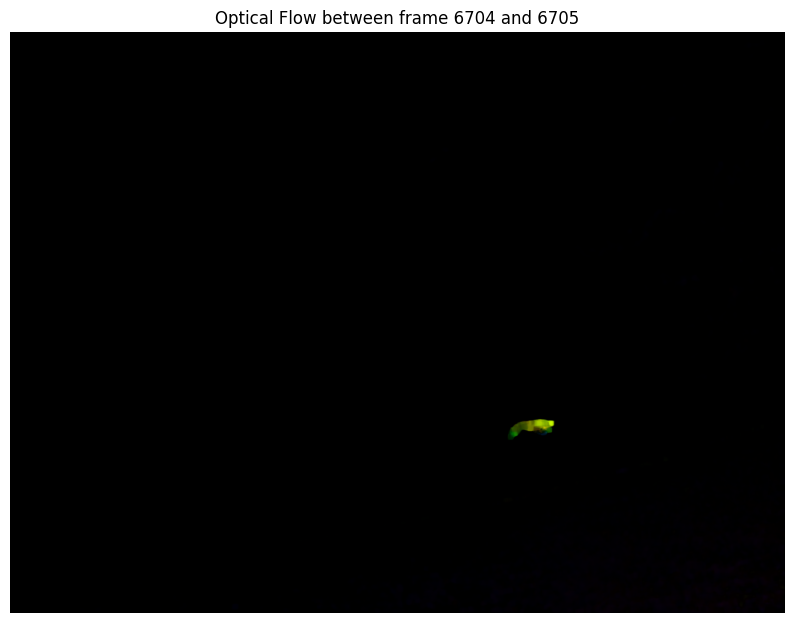

In [18]:
import zipfile
# Define the path to the zip file and extraction directory
zip_path = "C:\\Users\\hilal\\OneDrive\\Bureau\\Projet18\\DataSet\\images claires.zip"
extraction_path = "./images_claires"

# Extract the images from the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Define the path to the extracted images
image_files = [
    os.path.join(extraction_path, f"sequence=85_video-20220513_053645-02_frame={i}.jpg")
    for i in range(6700, 6706)
]

# Load the images
images = [cv2.imread(img_path) for img_path in image_files]

# Convert images to grayscale
gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

# Calculate optical flow using Farneback method
flows = []
for i in range(len(gray_images) - 1):
    flow = cv2.calcOpticalFlowFarneback(
        gray_images[i], gray_images[i + 1], None, 0.5, 3, 15, 3, 5, 1.2, 0
    )
    flows.append(flow)

# Plot the optical flow for each pair of frames
for i, flow in enumerate(flows):
    # Get flow components
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    
    # Create HSV image
    hsv = np.zeros_like(images[i])
    hsv[..., 1] = 255

    # Set hue according to the optical flow direction
    hsv[..., 0] = angle * 180 / np.pi / 2

    # Set value according to the optical flow magnitude (normalized)
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

    # Convert HSV to RGB (for visualization)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Plot the result
    plt.figure(figsize=(10, 10))
    plt.title(f'Optical Flow between frame {6700 + i} and {6701 + i}')
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()
